# Consult IT - preliminary elimination
## Team members (*Fratelli*):
1. Wiktor Jakubowski
2. Luca Nowosielski

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.cluster import AgglomerativeClustering

In [3]:
# load data
data = pd.read_excel('Baza_uczniów_CIT_2024.xlsx')
data.drop(['Imię', 'L.P.'], axis=1, inplace=True)

In [4]:
# check for missing values - there is none
data.isna().sum()

Płeć                     0
Wiek                     0
Język                    0
Poziom                   0
Hobby                    0
Typ prowadzenia zajęć    0
dtype: int64

In [20]:
### operations for categorical columns with order or binary values
ord_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

### operations for categorical unordered columns
cat_pipeline = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

### operations for numerical columns
num_pipeline = Pipeline(steps=[
    ('discretize', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'))
])

# Column transformer
col_trans = ColumnTransformer(transformers=[
    ('ord_pipeline', ord_pipeline, ['Płeć', 'Typ prowadzenia zajęć', 'Poziom']),
    ('cat_pipeline', cat_pipeline, ['Język', 'Hobby']),
    ('num_pipeline', num_pipeline, ['Wiek'])
],
remainder='drop',
n_jobs=-1)

# hierarchical clustering at the end of the pipeline (limit as desired number of people in the group)
model_pipeline = Pipeline([
    ('preprocessing', col_trans),
    #('clustering', AgglomerativeClustering(metric='euclidean', linkage='ward'))
])

In [21]:
# preprocess data
data_preprocessed = model_pipeline.fit_transform(data)

# convert compressed data to numpy array
decompressed_data = data_preprocessed.toarray()


/home/lmn20/anaconda3/envs/consult_it_env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


### Agglomerative clustering

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [54]:
import numpy as np

##### (a) Without constraint on the number of clusters

In [30]:
# initialise model
AC_model = AgglomerativeClustering(metric='euclidean', linkage='ward')

# fit model
clustered_data = AC_model.fit_predict(decompressed_data)

In [32]:
# Initialize TSNE model with desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Perform t-SNE on the data
tsne_result = tsne.fit_transform(decompressed_data)

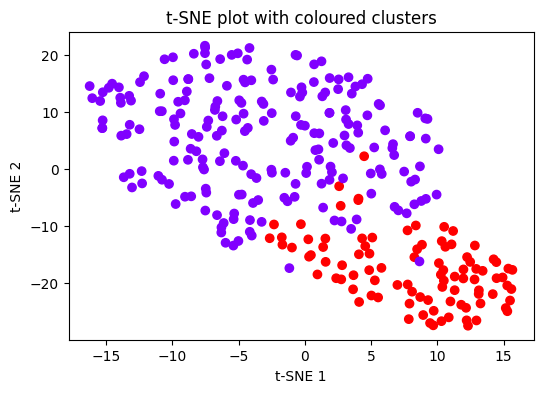

In [33]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clustered_data, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

##### (b) With constraint on the number of clusters

In [34]:
# define model for 30 clusters of 300 observations
AC_model_30 = AgglomerativeClustering(n_clusters = 30, metric='euclidean', linkage='ward')

# fit model
clustered_data_30 = AC_model_30.fit_predict(decompressed_data)

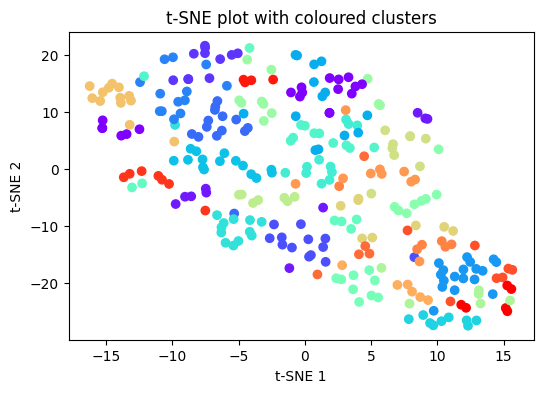

In [35]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clustered_data_30, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

The cluster sizes are:  [19, 10, 11, 13, 14, 13, 18, 14, 15, 9, 13, 11, 11, 7, 9, 8, 11, 6, 7, 9, 8, 13, 6, 10, 6, 5, 7, 7, 4, 6]


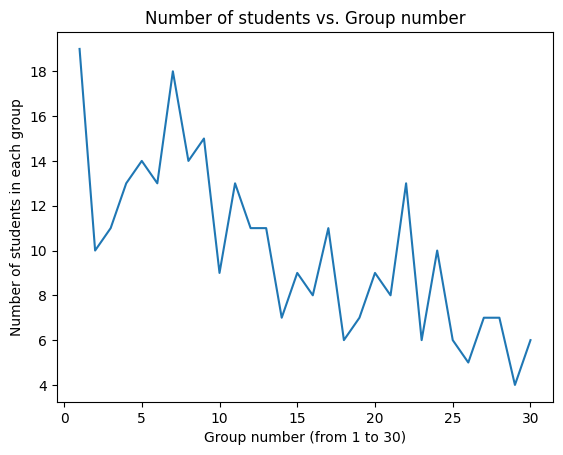

In [66]:
# check the cluster sizes

cluster_sizes = []

for i in range(30):
    
    cluster_sizes.append(clustered_data_30.tolist().count(i))

print('The cluster sizes are: ', cluster_sizes)

plt.plot(np.arange(1,31), cluster_sizes)
plt.xlabel('Group number (from 1 to 30)')
plt.ylabel('Number of students in each group')
plt.title('Number of students vs. Group number')
plt.show()

The cluster sizes have a clearly descending trend, the class sizes are not balanced. 
A hard limit to cluster sizes needs to be introduced, however it has the inherent risk of forcing some similar datapoints to be grouped in separate clusters with dissimilar datapoints

In [41]:
from sklearn.metrics import silhouette_score

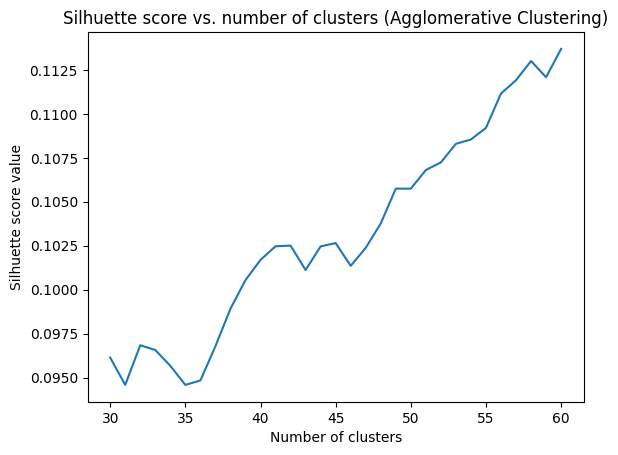

In [67]:
silhouette_list = []

for clusters in range(30, 61):

    # train the model for current number of clusters
    model = AgglomerativeClustering(n_clusters = clusters, 
                                    metric='euclidean', 
                                    linkage='ward')
    
    label = model.fit_predict(decompressed_data)

    silhouette_list.append(silhouette_score(decompressed_data, label))

#pd.DataFrame.from_dict({"Silhouette values": silhouette_list})

plt.plot(np.arange(30, 61), silhouette_list)
plt.xlabel('Number of clusters')
plt.ylabel('Silhuette score value')
plt.title('Silhuette score vs. number of clusters (Agglomerative Clustering)')
plt.show()

The silhouette score naturally increases, since smaller clusters would include a narrower range of datapoints with less variance. However, in a given range (of the number of clusters) a local maximum of the silhouette score can be picked for optimal clustering

In [ ]:
# implementation of agglomerative clustering with constraint on cluster sizes in this cell

### K-Means constrained

https://pypi.org/project/k-means-constrained/

Nice article about the algorithm: 

https://towardsdatascience.com/advanced-k-means-controlling-groups-sizes-and-selecting-features-a998df7e6745